In [2]:
import os

from src.pipeline.dataloader import DataLoader
from src.pipeline.taskloader import TaskLoader, TaskFrame

from src.settings import Strategy

from src.models.linear import GLM

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

In [3]:
DataLoader.DATA_FOLDER = './data/'
dl = DataLoader()
tl = TaskLoader()

glm = GLM()

In [4]:
df = dl.get_simple_protein_metabolite_dataframe()
gen = tl.prepare_task(df).build(Strategy.METABOLITE_CENTRIC)

/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:64: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


In [5]:
tf: TaskFrame = next(gen)
print(tf.frame_name)
x, y = tf.x, tf.y
res = glm.fit(x.reset_index(drop=True), y.reset_index(drop=True))
res.summary()

3pg;2pg


/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['familiy']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                     
====================================================================================
Dep. Variable:     metabolite_concentration   No. Observations:                69696
Model:                                  GLM   Df Residuals:                    69695
Model Family:                      Gaussian   Df Model:                            0
Link Function:                     identity   Scale:                      1.0546e+05
Method:                                IRLS   Log-Likelihood:            -5.0195e+05
Date:                      Wed, 17 Aug 2022   Deviance:                   7.3500e+09
Time:                              23:50:17   Pearson chi2:                 7.35e+09
No. Iterations:                           3   Pseudo R-squ. (CS):            -0.2553
Covariance Type:                  nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
enzyme_concentration   108.1578      0.190    568.058      0.000     107.785     108.531
========================================================================================
"""

<AxesSubplot:xlabel='enzyme_concentration', ylabel='metabolite_concentration'>

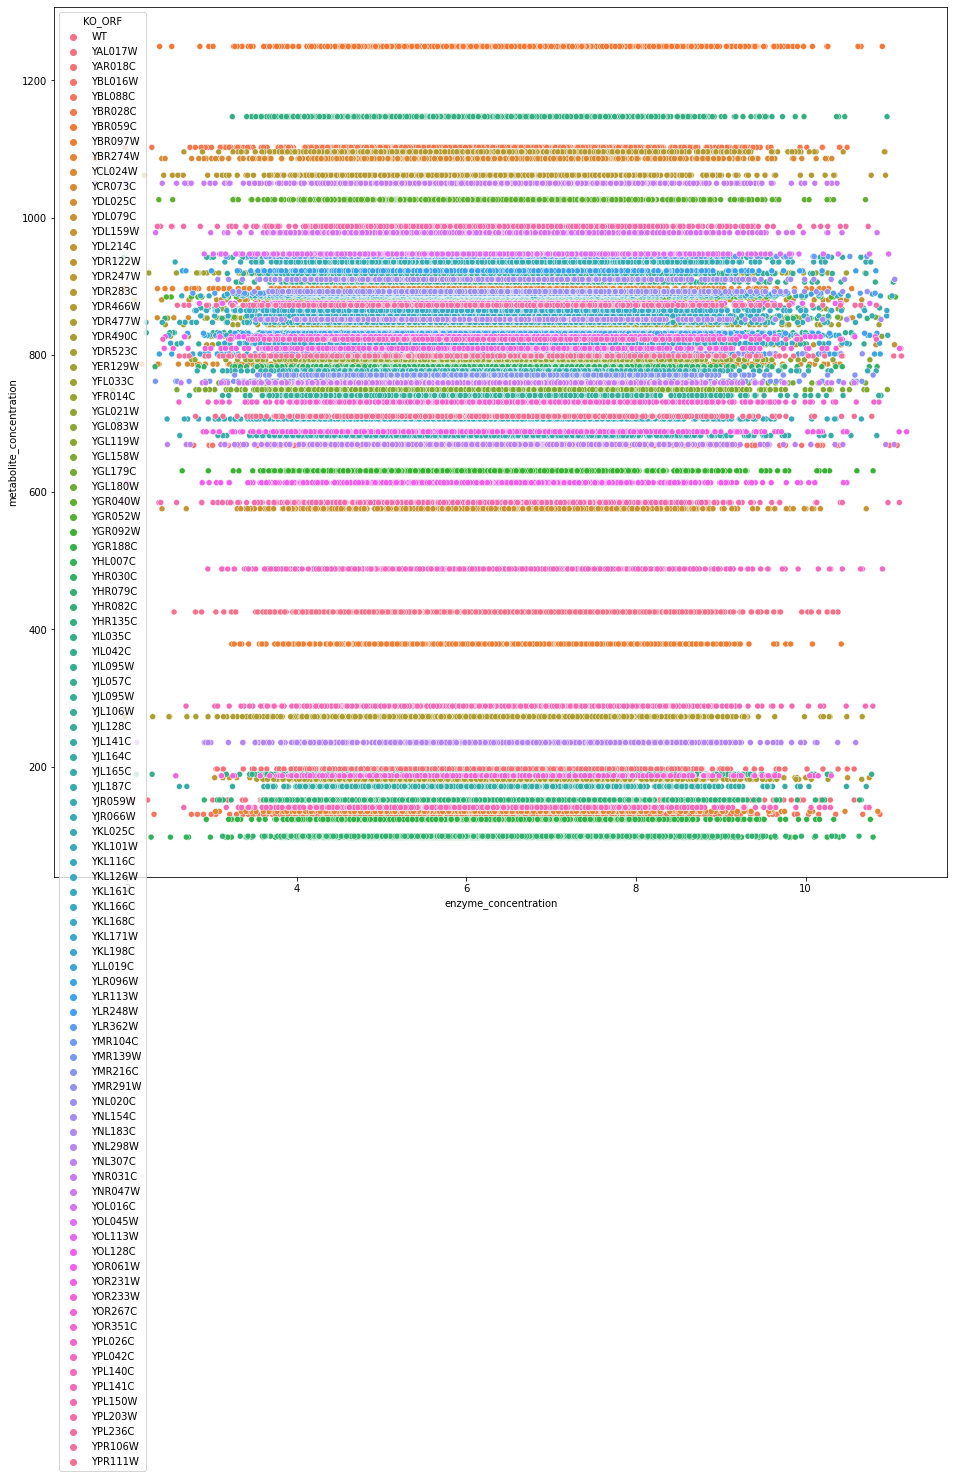

In [6]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.scatterplot(
    data=tf.get_data().reset_index(),
    hue='KO_ORF',
    x='enzyme_concentration',
    y='metabolite_concentration',
    ax=ax
)

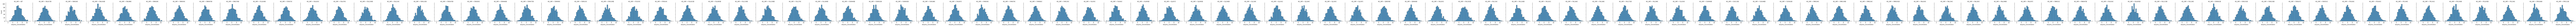

In [7]:
g = sns.FacetGrid(
    data=tf.x.reset_index(),
    col='KO_ORF'
)
g.map(sns.histplot, "enzyme_concentration")

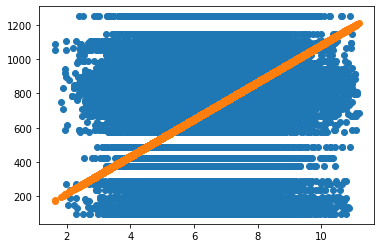

In [8]:
fig, ax = plt.subplots()
ax.scatter(tf.x, tf.y, label="Data")
ax.scatter(tf.x, res.predict(tf.x), label="Predict")

In [9]:
df = dl.get_simple_protein_metabolite_dataframe()
gen = tl.prepare_task(df).build(Strategy.ALL)
tf = next(gen)

/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:64: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


# Model building

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, GammaRegressor

from sklearn.metrics import mean_absolute_error

## Metabolite centric strategy

In [11]:
params = [{
    'regressor__regressor': [GammaRegressor()],
    'regressor__regressor__alpha': [0, 1, 10],
    'transformer': [MinMaxScaler()],
}, {
    'regressor__regressor': [DecisionTreeRegressor()],
    'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
    'regressor__regressor__max_depth': [None, 5, 10, 20, 15]
}, {
    'regressor__regressor': [SVR()],
    'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}, {
    'regressor__regressor': [ElasticNet()],
    'regressor__regressor__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
}]

In [12]:
df = dl.get_simple_protein_metabolite_dataframe()
gen = tl.prepare_task(df).build(Strategy.METABOLITE_CENTRIC)

/home/tvangraft/tudelft/thesis/metaengineering/src/pipeline/dataloader.py:64: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self.current_frame = AnnData(


In [17]:
numeric_features = ['enzyme_concentration']
numeric_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

cat_features = ['KO_ORF', 'ORF']
categorical_transformer = OneHotEncoder(
    categories=[
        tf.x.reset_index()['KO_ORF'].unique(),
        tf.x.reset_index()['ORF'].unique()
    ]
)

prepocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features),
    ]
)

estimator = DecisionTreeRegressor()
selector = RFE(
    estimator, 
    step=10,
)

clf = Pipeline(
    steps=[
        ('preprocessor', prepocessor),
        # ('select', selector),
        ('regressor', estimator),
    ]
)

model = TransformedTargetRegressor(
    regressor=clf,
    transformer=StandardScaler(),
    # func=np.log,
    # inverse_func=np.exp
)

cv = RepeatedKFold(n_repeats=10, random_state=0)

for tf in gen:
    if not(os.path.exists(f'{tf.title}_{tf.frame_name}.csv')):
        print(f'Training: {tf.title}_{tf.frame_name}.csv')

        df = tf.x.reset_index()
        X_train, X_test, y_train, y_test = train_test_split(
            df,
            tf.y,
            test_size=0.2,
            random_state=0,
            shuffle=False
        )

        search = GridSearchCV(
            model,
            params,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            refit=True,
            cv=cv,
            verbose=3,
        )
        search.fit(X_train, y_train)

        df = pd.DataFrame(search.cv_results_)
        df.to_csv(f'{tf.title}_{tf.frame_name}.csv')


# model.fit(X_train, y_train)
# n_scores = cross_val_score(
#     model, 
#     X_train, y_train, 
#     scoring='neg_mean_absolute_error', 
#     cv = cv,
#     verbose=1,
#     n_jobs=-1
# )

# model.fit(X_train, y_train)


print("model score: %.3f" % search.score(X_test, y_test))
mean_absolute_error(y_test, search.predict(X_test))

model score: -3212.609


3212.6085285292693

In [14]:
import pandas as pd

df = pd.DataFrame(search.cv_results_)
df.to_csv('save.csv')

In [15]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__regressor,param_regressor__regressor__alpha,param_transformer,param_regressor__regressor__criterion,param_regressor__regressor__max_depth,param_regressor__regressor__kernel,...,split43_test_score,split44_test_score,split45_test_score,split46_test_score,split47_test_score,split48_test_score,split49_test_score,mean_test_score,std_test_score,rank_test_score
8,0.141881,0.020366,0.010250,0.000945,DecisionTreeRegressor(criterion='friedman_mse'),NaN,NaN,friedman_mse,None,NaN,...,-1.897006e-11,-1.818262e-11,-1.575041e-11,-2.160361e-11,-2.476566e-11,-1.750704e-11,-2.597150e-11,-1.957351e-11,3.294989e-12,1
3,0.157630,0.025037,0.009905,0.001186,DecisionTreeRegressor(criterion='friedman_mse'),NaN,NaN,squared_error,None,NaN,...,-2.076304e-11,-1.923028e-11,-1.938056e-11,-2.568173e-11,-2.715314e-11,-1.702496e-11,-2.908761e-11,-2.193901e-11,3.478305e-12,2
14,93.970072,8.926388,0.919761,0.120014,SVR(),NaN,NaN,NaN,NaN,poly,...,-4.367860e+02,-4.411648e+02,-4.419802e+02,-4.357308e+02,-4.326662e+02,-4.392198e+02,-4.334154e+02,-4.366412e+02,2.184762e+00,3
13,0.782575,0.394563,0.047990,0.016687,SVR(),NaN,NaN,NaN,NaN,linear,...,-4.587912e+02,-4.616117e+02,-4.588614e+02,-4.580795e+02,-4.574516e+02,-4.593608e+02,-4.610308e+02,-4.589703e+02,1.184794e+00,4
15,83.962779,4.661908,1.658515,0.219341,SVR(),NaN,NaN,NaN,NaN,rbf,...,-4.662924e+02,-4.693290e+02,-4.684013e+02,-4.656266e+02,-4.643200e+02,-4.651034e+02,-4.684341e+02,-4.663522e+02,1.426703e+00,5
11,0.102181,0.015278,0.009839,0.001053,DecisionTreeRegressor(criterion='friedman_mse'),NaN,NaN,friedman_mse,20,NaN,...,-1.023368e+03,-9.563415e+02,-9.661902e+02,-9.177051e+02,-1.010147e+03,-9.464320e+02,-9.646028e+02,-9.683145e+02,2.469424e+01,6
6,0.103041,0.011604,0.010089,0.001365,DecisionTreeRegressor(criterion='friedman_mse'),NaN,NaN,squared_error,20,NaN,...,-1.023368e+03,-9.563415e+02,-9.661902e+02,-9.177051e+02,-1.010147e+03,-9.464320e+02,-9.646028e+02,-9.683145e+02,2.469424e+01,7
12,0.092881,0.014507,0.012789,0.003692,DecisionTreeRegressor(criterion='friedman_mse'),NaN,NaN,friedman_mse,15,NaN,...,-1.491818e+03,-1.453541e+03,-1.439657e+03,-1.404739e+03,-1.466123e+03,-1.447979e+03,-1.427590e+03,-1.435678e+03,1.975690e+01,8
7,0.090798,0.017571,0.010076,0.001324,DecisionTreeRegressor(criterion='friedman_mse'),NaN,NaN,squared_error,15,NaN,...,-1.491818e+03,-1.453541e+03,-1.439657e+03,-1.404739e+03,-1.466123e+03,-1.447979e+03,-1.427590e+03,-1.435678e+03,1.975690e+01,9
10,0.075762,0.014819,0.011357,0.004945,DecisionTreeRegressor(criterion='friedman_mse'),NaN,NaN,friedman_mse,10,NaN,...,-2.022538e+03,-2.030449e+03,-1.982869e+03,-1.993947e+03,-2.026280e+03,-1.991151e+03,-2.025490e+03,-2.003951e+03,1.803573e+01,10


In [16]:
dt: DecisionTreeRegressor = model.regressor.named_steps['select']
dt.n_features_

KeyError: 'select'

In [ ]:
len(set(y_train.unique()).difference(set(y_test.unique())))

76

<AxesSubplot:xlabel='enzyme_concentration', ylabel='Count'>

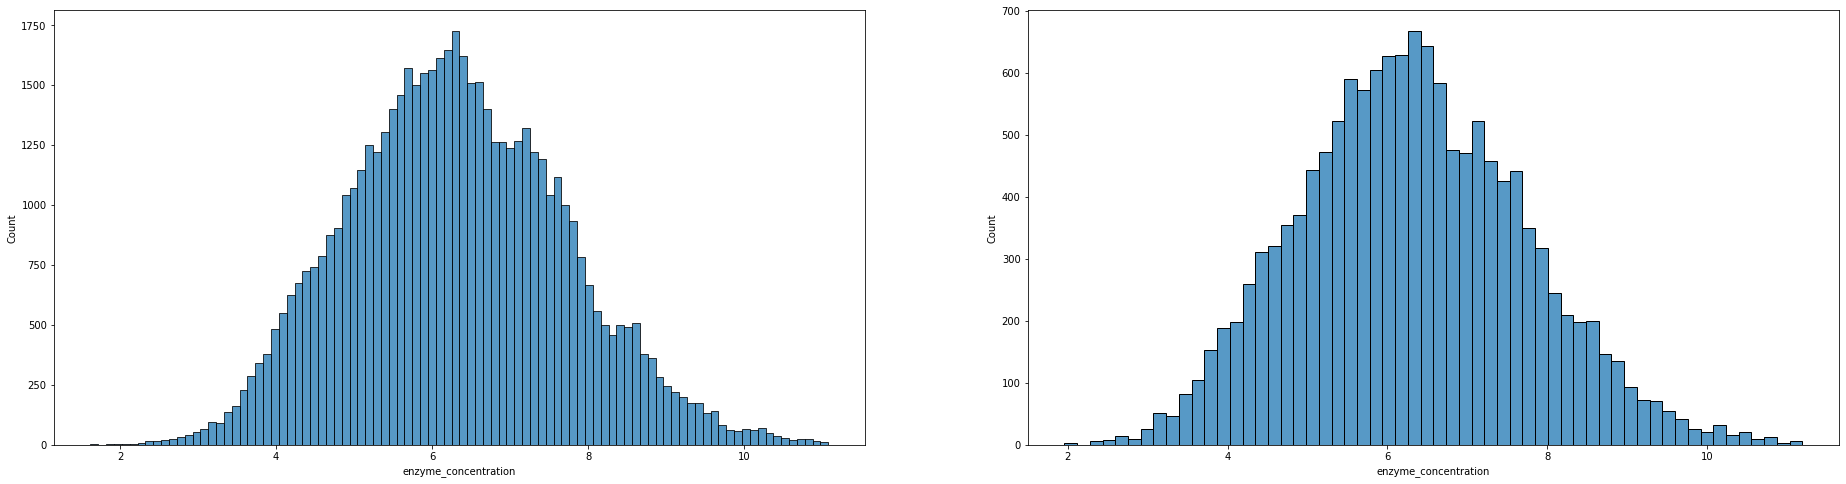

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 8))
sns.histplot(X_train['enzyme_concentration'], ax=ax1)
sns.histplot(X_test['enzyme_concentration'], ax=ax2)

<AxesSubplot:xlabel='metabolite_concentration', ylabel='Count'>

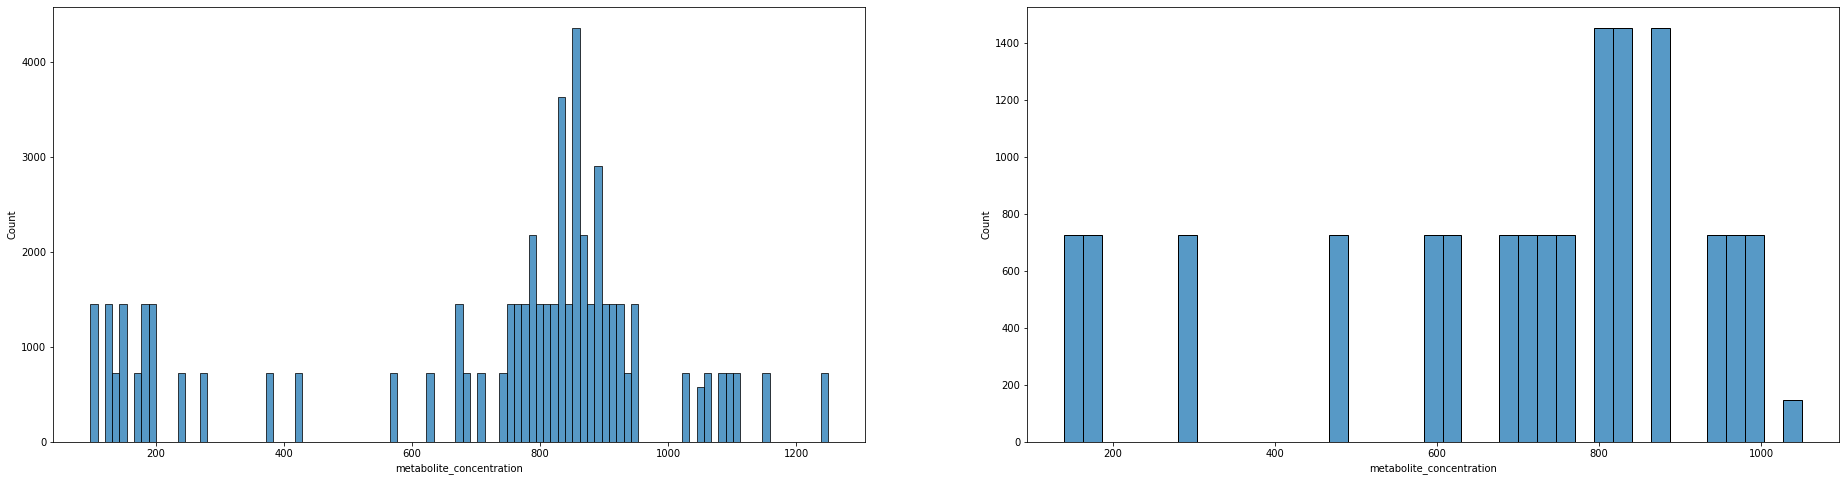

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 8))
sns.histplot(y_train, ax=ax1)
sns.histplot(y_test, ax=ax2)

In [ ]:
clf['regressor'].regressor

DecisionTreeRegressor()

In [ ]:
fig, ax = plt.subplots(figsize=(64, 64))
plot_tree(
    model.regressor.named_steps['regressor']
)

In [ ]:
transform = make_column_transformer(
    (OneHotEncoder(), ['KO_ORF', 'ORF'])
)

In [ ]:

df = transform.fit_transform(df)



In [ ]:
X_train

,KO_ORF,ORF,enzyme_concentration
36254,YJL165C,YPL028W,7.928044
28857,YHR135C,YMR116C,9.429324
58631,YOL113W,YMR203W,5.563761
38196,YJR066W,YKR074W,5.023174
45294,YLL019C,YGR180C,7.942237
...,...,...,...
21243,YGL179C,YER003C,7.177314
45891,YLR096W,YDR304C,6.456569
42613,YKL166C,YLR429W,5.862710
43567,YKL171W,YAL044C,7.113592


In [ ]:
dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)
dt.score(X_test, y_test)

mean_squared_error(y_test, dt.predict(X_test))

ValueError: could not convert string to float: 'YJL165C'

In [ ]:
svr = SVR()
svr.score(X_test, y_test)

In [ ]:
mean_squared_error(y_test, svr.predict(X_test))